In [1]:
import pandas as pd
import cvxpy as cp
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import math
from cvxopt import solvers,matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error
import scipy.sparse as sp
import gurobipy as gp
import math
import scipy as sp1
import sympy as smp
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

In [2]:
#dataset load
data=pd.read_csv('sample.csv')
data.head()

,Strike,Vol,Underlying,Tau to maturity,Interest Rate,Price
0,1095,0,1206.0699,17,0.000548,111.25
1,1100,90,1206.0699,17,0.000548,106.55
2,1105,0,1206.0699,17,0.000548,101.55
3,1110,10,1206.0699,17,0.000548,96.75
4,1115,1,1206.0699,17,0.000548,92.00


In [3]:
print(data.shape)

(60, 6)


In [4]:
Strike = np.array(data.iloc[:,0])
C=data.iloc[:,5]
n = len(Strike)
d1=0.05*(pow(n/200,3/2))
gamma=.05
# lamda=1/np.min([1,d1])
lamda=16
epsilon=.01
r=0.000548
t=17/365
S_0=1206.069
delt=0
# print(lamda)

In [5]:
# Define kernel function
def kernel(x,x_i):
    return math.exp(-gamma*(x-x_i)**2)
# Construct the kernel matrix
def construct_kernel_matrix(points, kernel_func):
    n = len(points)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            M[i, j] = round(kernel_func(points[i], points[j]),2)
    return M
M = construct_kernel_matrix(Strike, kernel)

In [6]:
# construct matrix for objective function
def construct_block_matrix(M, lambda_):
    n = M.shape[0]  # assuming M is a square matrix of size n x n
    I = np.identity(n)
    
    # Construct the block matrix
    top = np.hstack((1/2 * M, np.zeros((n, n))))
    bottom = np.hstack((np.zeros((n, n)), lambda_ * I))
    block_matrix = np.vstack((top, bottom))
    
    return block_matrix

block_matrix = construct_block_matrix(M, 2)

In [7]:
# Terms needed in constraints
def tr(x,y): 
    return (pow(np.pi/gamma,1/2)/2)*(y-x)*(math.erf((y-x)*pow(gamma,1/2))+1)
def tr1(x):
    return (pow(np.pi/gamma,1/2)/2)*(math.erf(x*pow(gamma,1/2))+1) # function for integral equals to 1 for Density constraint
def tr2(x):
    return (1/(2*gamma))*(np.exp(-gamma*(pow(x,2))))+x*tr1(x) # C(0) = S_0*e^(−δt)
dis_count=(np.exp(-r*t))

In [8]:
# Create two n*n matrices filled with zeros
# Create coefficient matrix for constraints
matrix11 = [[0 for _ in range(n)] for _ in range(n)]
matrix21 = [[0 for _ in range(n)] for _ in range(n)]

for i in range(n):
    for j in range(n):
        matrix11[i][j] = dis_count*((kernel(Strike[i],Strike[j])/(2*gamma))+tr(Strike[i],Strike[j]))
        
matrix21=-np.eye(n)

# Combine the two matrices to form an n*2n matrix
combined_matrix = np.hstack((matrix11, matrix21))
G=np.array(combined_matrix)

In [9]:
# Create two n*n matrices filled with zeros
# Create coefficient matrix for constraints
matrix1 = [[0 for _ in range(n)] for _ in range(n)]
matrix2 = [[0 for _ in range(n)] for _ in range(n)]

for i in range(n):
    for j in range(n):
        matrix1[i][j] = -dis_count*((kernel(Strike[i],Strike[j])/(2*gamma))+tr(Strike[i],Strike[j]))
matrix2=-np.eye(n)

# Combine the two matrices to form an n*2n matrix
combined_matrix = np.hstack((matrix1, matrix2))
G1=np.array(combined_matrix)

In [10]:
# Create coefficient matrix for constraints
combined_matrix3=np.zeros(2*n)
for i in range(n):
        combined_matrix3[i] = tr1(Strike[i])
G3=np.array(combined_matrix3)

In [11]:
# Create coefficient matrix for constraints
matrix5 = []
for i in range(n):
        matrix5.append(tr2(Strike[i]))
matrix6 = []
for i in range(n):
        matrix6.append(0)
combined_matrix3 = np.hstack((matrix5, matrix6))
G4=dis_count*np.array(combined_matrix3)

In [12]:
# Positivity constraint
zero_matrix = np.zeros((n, n))
combined_matrix7 = np.hstack((M, zero_matrix))
G7=np.array(combined_matrix7)

In [13]:
h = np.zeros((n, 1))
for i in range(n):
    h[i][0] = C[i]+epsilon
h1 = np.zeros((n, 1))
for i in range(n):
    h1[i][0] = epsilon-C[i]
q = np.zeros((2*n, 1))

In [14]:
# Define the variable
X= cp.Variable((2*n,1))
objective = cp.Minimize(0.5*cp.quad_form(X, block_matrix)+q.T @ X)
# Define the constraints
constraints = [G @ X <= h,G1@X<=h1,G7@X>=0,G3@X==1,G4@X==S_0]

problem = cp.Problem(objective,constraints)
problem.solve(solver=cp.CLARABEL, verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 26 09:01:51 PM: Your problem has 120 variables, 182 constraints, and 0 parameters.
(CVXPY) Jun 26 09:01:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 09:01:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 09:01:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 26 09:01:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 09:01:51 PM: Compiling problem (target solver=CLARABEL

0.7530826643325833

In [15]:
# Print the result
print("Status:", problem.status)
print("Optimal value:", problem.value)
print("Optimal variable:", X.value)

Status: optimal
Optimal value: 0.7530826643325833
Optimal variable: [[ 7.25546402e-03]
 [-2.31472292e-03]
 [ 7.44952543e-04]
 [-5.39788299e-04]
 [ 1.03010709e-03]
 [ 4.81682405e-03]
 [-1.55106241e-03]
 [ 5.09900909e-04]
 [-3.98889824e-04]
 [ 7.41699770e-04]
 [ 5.14362522e-03]
 [-9.66296056e-04]
 [-2.24895595e-03]
 [ 1.19424973e-02]
 [-2.75522587e-03]
 [-2.87166261e-03]
 [ 1.47173370e-02]
 [-1.69222899e-03]
 [-1.00345496e-02]
 [ 3.62937290e-02]
 [-1.47058744e-02]
 [ 1.47134836e-02]
 [ 1.41282200e-03]
 [-1.14230859e-03]
 [ 1.58074815e-02]
 [-1.45967224e-02]
 [ 4.08599485e-02]
 [-1.66761117e-02]
 [ 1.73457469e-02]
 [-5.75727517e-03]
 [ 1.27476079e-02]
 [ 5.87814848e-03]
 [-4.76626439e-03]
 [ 1.33813796e-02]
 [-3.37745326e-03]
 [-1.90051884e-03]
 [ 9.56662982e-03]
 [-2.81560689e-03]
 [ 1.37790139e-04]
 [ 2.03302915e-03]
 [-6.50888449e-04]
 [ 2.12337446e-04]
 [-1.64575552e-04]
 [ 3.81682882e-04]
 [-1.18145677e-04]
 [ 3.14914010e-05]
 [-2.91047964e-06]
 [-2.01943271e-05]
 [ 8.15785811e-05]
 

In [16]:
alpha=X.value[0:n]

In [17]:
ker_mat=np.matrix(matrix11)

In [18]:
est_prc=np.matmul(ker_mat,alpha)
est_prc=np.array(est_prc)

In [19]:
est_prc[0]

array([111.16809478])

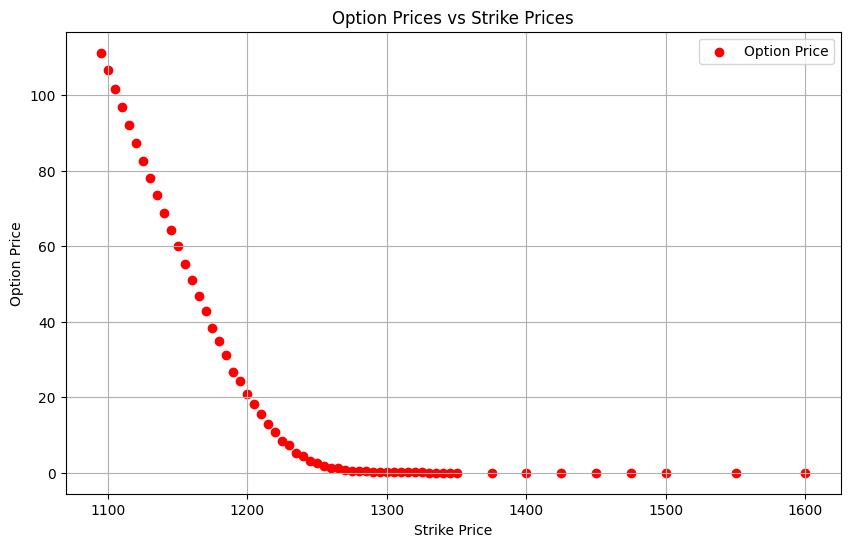

In [31]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(Strike, C,color='r',label='Option Price')
# Add titles and labels
plt.title('Option Prices vs Strike Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


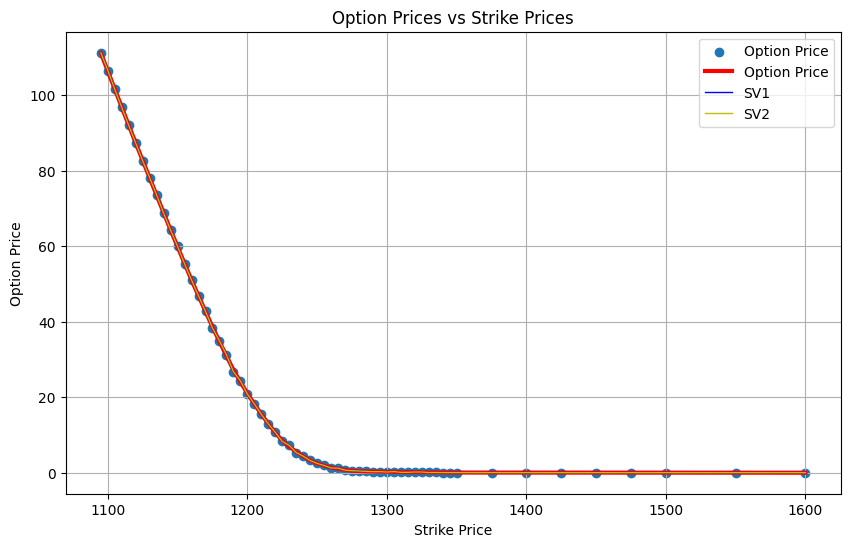

In [33]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(Strike, C, label='Option Price')
# Create a visualization
plt.plot(Strike, est_prc,linestyle='-',linewidth=3,color='r', label='Option Price')
plt.plot(Strike, C+epsilon, linestyle='-', linewidth=1,color='b', label='SV1')
plt.plot(Strike, C-epsilon, linestyle='-',linewidth=1, color='y', label='SV2')
# Add titles and labels
plt.title('Option Prices vs Strike Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [22]:
MSE=mean_squared_error(np.array(C),np.array(est_prc))
MAE=mean_absolute_error(np.array(C),np.array(est_prc))
RMSE=pow(mean_squared_error(np.array(C),np.array(est_prc)),1/2)

In [23]:
print(MSE,MAE,RMSE)

0.013974109126282304 0.07654030092955434 0.11821213612096816


In [24]:
C=np.array(C)
se=np.array(est_prc)
err=[]
err1=[]
for i in range(len(C)):
    e=abs(((C[i]-se[i])/C[i])*100)
    e1=C[i]-se[i]
    err.append(e)
    err1.append(e1)

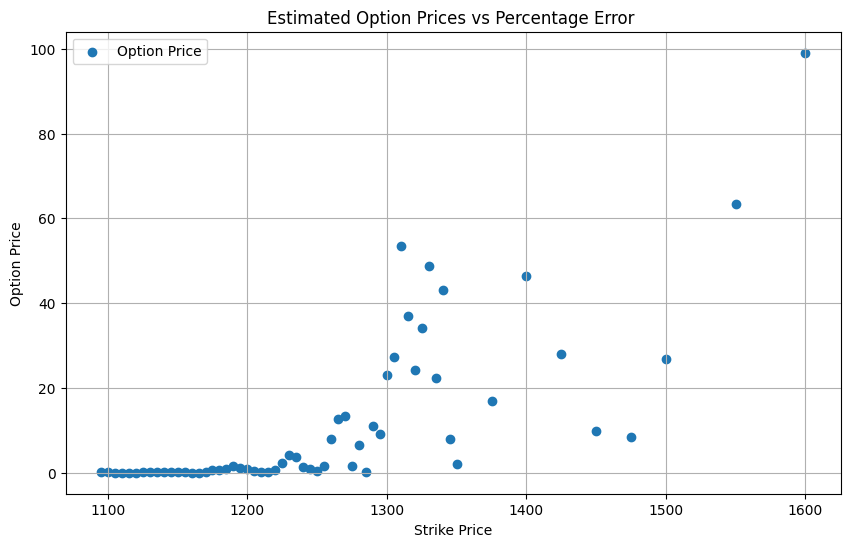

In [25]:
# Create the plot Strike vs. Percentage Error
plt.figure(figsize=(10, 6))
plt.scatter(Strike, err,label='Option Price')
# plt.plot(points, se, marker='*', linestyle='-', color='r', label='Estimated Option Price')
# Add titles and labels
plt.title('Estimated Option Prices vs Percentage Error ')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


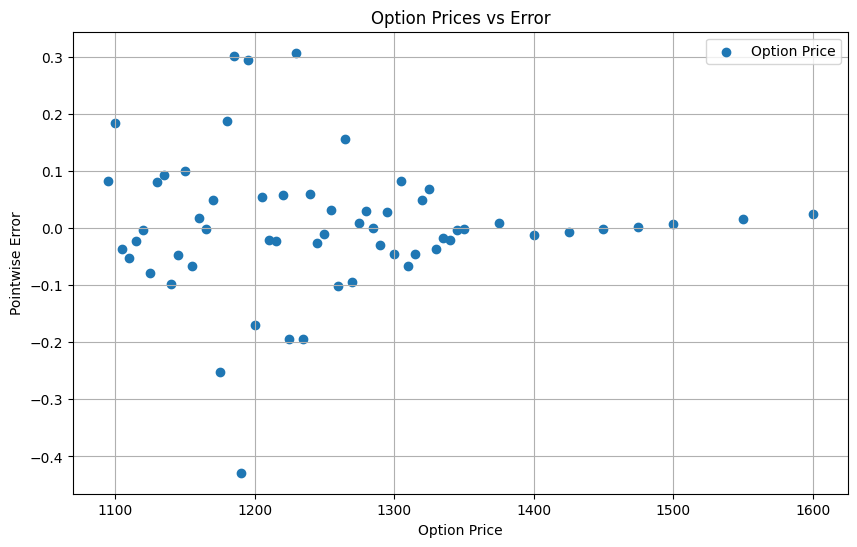

In [26]:
# Create the plot Strike vs. Error
plt.figure(figsize=(10, 6))
plt.scatter(Strike, err1,label='Option Price')
# plt.plot(points, se, marker='*', linestyle='-', color='r', label='Estimated Option Price')
# Add titles and labels
plt.title('Option Prices vs Error')
plt.xlabel('Option Price')
plt.ylabel('Pointwise Error')
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [27]:
mm=Strike*dis_count/S_0 #moneyness = K/S*e^(r*t)

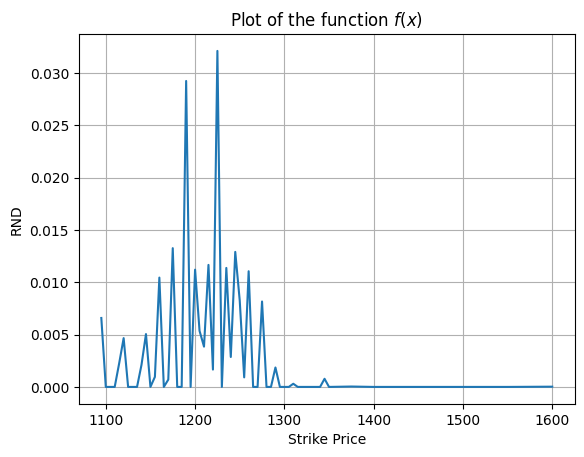

In [28]:
# Example values for α_i
y_values=M@alpha
val=pd.DataFrame(y_values)
y_values=np.array(val.iloc[:,0])
# Plot the RND function discrete
sns.lineplot(x=Strike, y=y_values)
plt.xlabel('Strike Price')
plt.ylabel('RND')
plt.title('Plot of the function $f(x)$')
plt.grid(True)
plt.show()